# Segmentation of Lung CT scans

Data used in project can be downloaded via following link: http://medicaldecathlon.com/

## Intorduction

The idea of this project is to take input data in the form of a CT scan of the lungs, create and train a model which will do their segmentation and find abnormalities if they exist.

The typical use of convolutional neural networks is on classification tasks, where the output of an image is a single class label. In the problem that we are considering, we definitely should classify CT scans, but we also need to locate abnormalities if they exist. To do that, it is necessary to assign a label to each pixel of the CT scan. Of course, we are going to have two labels: normal and abnormal. All pixels that are classified as abnormal, together construct the abnormality of the considering lungs.

The model will be a convolutional neural network based on the U-net architecture.

#### What is U-net architecture and why we are going to use it?

The U-net architecture, the so-called "fully convolutional network," was designed in 2015. for the segmentation of biomedical images. U-Net has been successfully used in numerous studies and clinical applications for CT scan segmentation. 

It has a symetric structure in the shape of the letter U, and it consists of two main parts: the contracting path (coder) and the expansive path (decoder). This symmetric design of U-Net ensures a balanced extraction and reconstruction of features, leading to more accurate segmentation, which will be very useful considering the complex lung structures.

## Libraries

In [5]:
import os

import json
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
from torchvision.io import read_image

from tqdm import tqdm 

## Data Load and Preproccessing

In [32]:
def ct_to_slices(path):
    data = nib.load(path).get_fdata()
    [_, _, slices] = data.shape
    
    return [data[..., slice] for slice in range(slices)]

In [35]:
def calc_hounsfield(slices):
    hounsfield_min = min([np.min(slice) for slice in slices])
    hounsfield_max = max([np.max(slice) for slice in slices])
    
    return hounsfield_min, hounsfield_max

In [36]:
def normalize_slice(slice, hounsfield_min, hounsfield_max):
    slice[slice < hounsfield_min] = hounsfield_min
    slice[slice > hounsfield_max] = hounsfield_max
    slice = (slice - hounsfield_min) / (hounsfield_max - hounsfield_min)
    
    return slice

In [50]:
from PIL import Image

def convert_ct_dataset_to_slices(dataset_dir, output_dir):
    os.mkdir(output_dir)
    
    images_dir = os.path.join(output_dir, 'imagesTr')
    labels_dir = os.path.join(output_dir, 'labelsTr')
    os.mkdir(images_dir)
    os.mkdir(labels_dir)
    
    image_paths = None
    label_paths = None
    
    with open(os.path.join(dataset_dir, 'dataset.json'), 'r') as dataset_info:
        data = json.load(dataset_info)
        image_paths = [os.path.join(dataset_dir, scan['image']) for scan in data['training']]
        label_paths = [os.path.join(dataset_dir, scan['label']) for scan in data['training']]
        
    for (i, path) in enumerate(image_paths):
        slices = ct_to_slices(path)
        hounsfield_min, hounsfield_max = calc_hounsfield(slices)
        for (j, slice) in enumerate(ct_to_slices(path)):
            # Normalize the slice from the Hounsfield scale
            slice = normalize_slice(slice, hounsfield_min, hounsfield_max) * 255
            # Convert to PIL Image in grayscale mode
            img = Image.fromarray(slice).convert('L')
            img.save(os.path.join(images_dir, f'{i + 1}_{j + 1}.png'))

    for (i, path) in enumerate(label_paths):
        for (j, slice) in enumerate(ct_to_slices(path)):
            slice = slice * 255
            # Convert to PIL Image in grayscale mode
            img = Image.fromarray(slice).convert('L')
            img.save(os.path.join(labels_dir, f'{i + 1}_{j + 1}.png'))

### Clicing 3D scans into 2D images 

In [51]:
convert_ct_dataset_to_slices('Task06_Lung', 'Task06_Lung_Sliced')

In [52]:
# load first image
image1_1 = read_image('Task06_Lung_Sliced/imagesTr/1_1.png').float() 

print(f"Image size (width, height): {image1_1.shape[1], image1_1.shape[2]}")
num_channels = image1_1.shape[0]
print(f"Number of channels: {num_channels}")

Image size (width, height): (512, 512)
Number of channels: 1


Before we load the data into the training set, we will need to downsize the images as previous size is too large!

In [53]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = num_channels # = 4 - sta ce nam 4 kanala za crno bele slike?

SLICED_DATA = 'Task06_Lung_Sliced'

IMAGES_TR_PATH = SLICED_DATA + "/imagesTr"
LABELS_TR_PATH = SLICED_DATA + "/labelsTr"

## --------------------------------------------------------------------------------------------------

## Provera za kanale - mozemo obrisati posle

IndexError: index 1 is out of bounds for dimension 0 with size 1

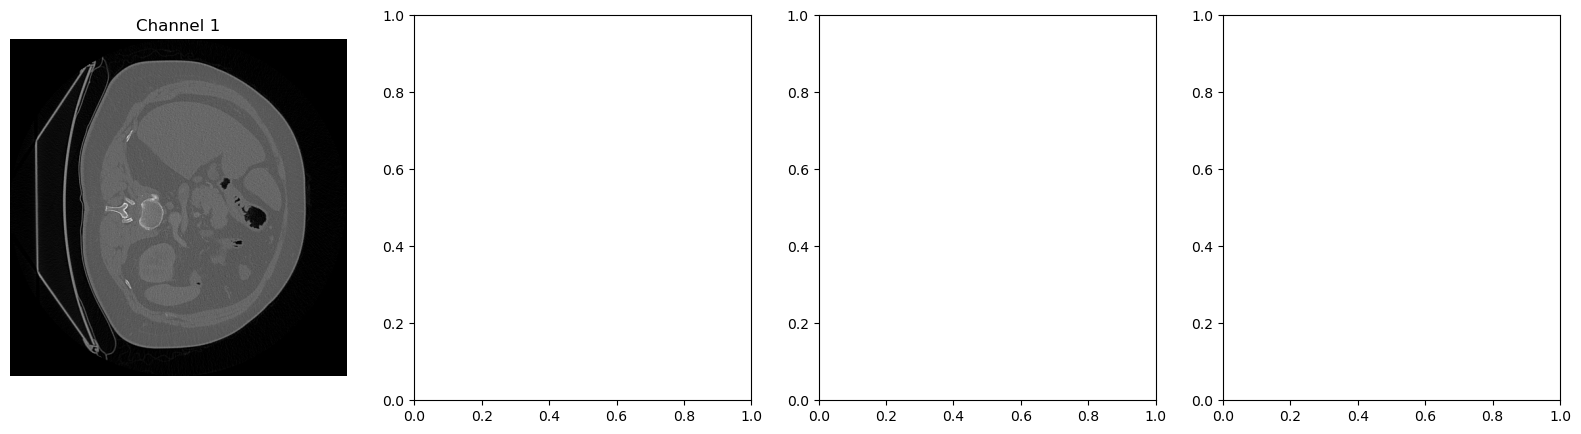

In [54]:
#provera za kanale slike - sta ce nam 4 kanala?
import matplotlib.pyplot as plt

# Assuming img is a 4-channel image
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(image1_1[i].numpy(), cmap='gray')
    axs[i].set_title(f'Channel {i+1}')
    axs[i].axis('off')

plt.show()

for i in range(4):
    channel = image1_1[i]
    print(f'Channel {i+1}: mean={channel.mean().item()}, min={channel.min().item()}, max={channel.max().item()}')

# prva tri kanala su ista -> ne trebaju nam sva tri, a i sve slike su crno bele

## --------------------------------------------------------------------------------------------------

Function to load sliced images, resize them and store them into np matrix, which we will use data.

In [12]:
def loadAndResize(images_names, dirPath, channels, height, width):
    storage = np.zeros((len(images_names), channels, height, width), dtype=np.uint8)
    for n, id_ in tqdm(enumerate(images_names), total=len(images_names)):   
        # load image and resize it
        img = read_image(dirPath + "/" + id_).float()  # [C, H, W] format
        img = resize(img, [height, width])  # Resize the image
        
        # normalize pixels
        img /= 255.0

        # store resized image
        storage[n] = img
    return storage

### Storing data for training

In [13]:
train_ids = next(os.walk(IMAGES_TR_PATH))[2]
# print(train_ids)

In [71]:
X_train = loadAndResize(train_ids, IMAGES_TR_PATH, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)
X_train[0]

  0%|                                                 | 0/17657 [00:00<?, ?it/s]/tmp/ipykernel_6480/2804555441.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  storage[n] = img
100%|█████████████████████████████████████| 17657/17657 [05:04<00:00, 58.05it/s]


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint8)

In [ ]:
Y_train = loadAndResize(train_ids, LABELS_TR_PATH, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)
Y_train[0]

  0%|                                                 | 0/17657 [00:00<?, ?it/s]/tmp/ipykernel_6480/2804555441.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  storage[n] = img
 83%|█████████████████████████████▉      | 14659/17657 [01:05<00:12, 239.66it/s]

In [9]:
# Ovo ce nam trebati prilikom treniranja modela - ako budemo resizeovali, mozda mozemo da to ubacimo
# kao image_transform i label_transform

from torch.utils.data import Dataset

class LungCTDataset(Dataset):
    def __init__(self, dataset_dir, image_transform=None, label_transform=None):
        image_dir = os.path.join(dataset_dir, 'imagesTr')
        image_names = os.listdir(image_dir)
        self.image_paths = [os.path.join(image_dir, image_name) for image_name in image_names]
        
        label_dir = os.path.join(dataset_dir, 'labelsTr')
        label_names = os.listdir(label_dir)
        self.label_paths = [os.path.join(label_dir, label_name) for label_name in label_names]
        
        self.image_transform = image_transform
        self.label_transform = label_transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = read_image(self.label_paths[idx])
        
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.label_transform:
            label = self.label_transform(label)
            
        return image, label

In [10]:
lungs = LungCTDataset('Task06_Lung_Sliced')
image, label = lungs.__getitem__(1581)

In [11]:
image.shape

torch.Size([1, 512, 512])

## Model creation

### U-Net 

In [29]:
# mislila sam da kada skontamo koje cemo dimenzije filtera itd da napravim ovakvu sliku za nasu arhitekturu i ubcaim ovako ako se slazes

<img src="metadata/u-net-architecture.png" alt="Alt Text" width="650"/>

In [16]:
# ovde sam rendom stavila neke brojke koje sam nasla na netu, podesicemo posle tacno sta zelimo

In [17]:
# razlika izmedju tensorflow-a i torcha je sto ovde imamo ovu forward fju kojom definisemo "kretanje" izmedju slojeva, 
# nije sve u jednoj liniji kao za tensorflow
# mozda ima i drugi nacin, ja sam nasla ovaj, ako ti se ne svidja mozemo da promenimo

In [31]:
# TODO: opciona funkcija za crtanje izmedju slojeva

Creating U-Net architecture

In [55]:
# Define the model class
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Coder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1_drop = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_drop = nn.Dropout(0.2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_drop = nn.Dropout(0.2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5_drop = nn.Dropout(0.3)
        
        # Max pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
        
    def forward(self, x):
        # Coder
        c1 = F.relu(self.conv1(x))
        c1 = F.relu(self.conv1_drop(self.conv1(c1)))
        p1 = self.pool(c1)
        
        c2 = F.relu(self.conv2(p1))
        c2 = F.relu(self.conv2_drop(self.conv2(c2)))
        p2 = self.pool(c2)
        
        c3 = F.relu(self.conv3(p2))
        c3 = F.relu(self.conv3_drop(self.conv3(c3)))
        p3 = self.pool(c3)
        
        c4 = F.relu(self.conv4(p3))
        c4 = F.relu(self.conv4_drop(self.conv4(c4)))
        p4 = self.pool(c4)
        
        c5 = F.relu(self.conv5(p4))
        c5 = F.relu(self.conv5_drop(self.conv5(c5)))
        
        # Decoder
        u6 = self.upconv1(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = F.relu(self.conv4(u6))
        c6 = F.relu(self.conv4_drop(self.conv4(c6)))

        u7 = self.upconv2(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = F.relu(self.conv3(u7))
        c7 = F.relu(self.conv3_drop(self.conv3(c7)))

        u8 = self.upconv3(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = F.relu(self.conv2(u8))
        c8 = F.relu(self.conv2_drop(self.conv2(c8)))

        u9 = self.upconv4(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = F.relu(self.conv1(u9))
        c9 = F.relu(self.conv1_drop(self.conv1(c9)))

        output = torch.sigmoid(self.final_conv(c9))
        return output

In [56]:
# Mmdel instantiation
model = UNet()

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

UNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_drop): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_drop): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_drop): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (upconv4): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
 

## Model evaluation and testing

In [ ]:
# TODO ...

## References

1. U-Net: Convolutional Networks for Biomedical Image Segmentation: Olaf Ronneberger, Philipp Fischer, and Thomas Brox - Computer Science Department and BIOSS Centre for Biological Signalling Studies, University of Freiburg, Germany